<h1>D(St)reams of Anomalies</h1>
<br>
This is a data science project where we are trying to find anomalies in a dataset. Instead of using a dataset that is labeled with the anomalies, I am going to use a dataset which does not identify anomalies and instead just have to use a ML model to predict the anomalies. 

In [38]:
#python imports
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
plt.close('all')
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

<h3><b> Dataset </b></h3>
<br>
Numenta Anomaly Benchmark (NAB) Datasets
Taken from: https://github.com/numenta/NAB/tree/master/data 
<br>
This data is twitter data for a number of fortune 500 companies. "The metric value represents the number of mentions for a given ticker symbol every 5 minutes". The other feature is the timestamp at which that happened.

In [4]:
aapl_df = pd.read_csv('../data/AAPL_twitter_volume.csv')
amzn_df = pd.read_csv('../data/AMZN_twitter_volume.csv')
crm_df = pd.read_csv('../data/CRM_twitter_volume.csv')
cvs_df = pd.read_csv('../data/CVS_twitter_volume.csv')
fb_df = pd.read_csv('../data/FB_twitter_volume.csv')

Here we are combining all of the data into one data frame for ease and also so that we have more data when training the model. 

In [135]:
aapl_df["company"] = "AAPL"
amzn_df["company"] = "AMZN"
crm_df["company"] = "CRM"
cvs_df["company"] = "CVS"
fb_df["company"] = "FB"
dfs = [aapl_df, amzn_df, crm_df, cvs_df, fb_df]
df = pd.concat(dfs)
df

,timestamp,value,company
0,2015-02-26 21:42:53,104,AAPL
1,2015-02-26 21:47:53,100,AAPL
2,2015-02-26 21:52:53,99,AAPL
3,2015-02-26 21:57:53,154,AAPL
4,2015-02-26 22:02:53,120,AAPL
...,...,...,...
15828,2015-04-22 20:42:53,93,FB
15829,2015-04-22 20:47:53,101,FB
15830,2015-04-22 20:52:53,132,FB
15831,2015-04-22 20:57:53,78,FB


After combining the data, we are now going to add more features. The only real piece of data we can expand is the time piece of data. From this data we added these different features:

• is_night: This is a bool that indicates whether the time is at night or night

• is_weekend: Another bool determining if it is the weekend when tweeted

• is_stock_hours: Because companies and people talk about them when the company stock changes, we can also say whether the stock market is open

• day_of_week: Number signifiying the day of the week

• hour: hour of day

• month: the month of tweets

• time of day: the time of day normalized between 0 and 1

In [136]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['is_night'] = ((df.timestamp.dt.hour >= 19) | (df.timestamp.dt.hour < 5)).astype(int)
df['is_weekend'] = (df.timestamp.dt.dayofweek >= 5).astype(int)
df['is_stock_hours'] = ((df.timestamp.dt.hour >= 9) & (df.timestamp.dt.hour < 17)).astype(int)
df["day_of_week"] = df.timestamp.dt.dayofweek
df["hour"] = df.timestamp.dt.hour
df["month"] = df.timestamp.dt.month
df["time_of_day"] = min_max_scaler.fit_transform((df.timestamp.dt.hour * 60 + df.timestamp.dt.minute).values.reshape(-1,1))
df

,timestamp,value,company,is_night,is_weekend,is_stock_hours,day_of_week,hour,month,time_of_day
0,2015-02-26 21:42:53,104,AAPL,1,0,0,3,21,2,0.905923
1,2015-02-26 21:47:53,100,AAPL,1,0,0,3,21,2,0.909408
2,2015-02-26 21:52:53,99,AAPL,1,0,0,3,21,2,0.912892
3,2015-02-26 21:57:53,154,AAPL,1,0,0,3,21,2,0.916376
4,2015-02-26 22:02:53,120,AAPL,1,0,0,3,22,2,0.919861
...,...,...,...,...,...,...,...,...,...,...
15828,2015-04-22 20:42:53,93,FB,1,0,0,2,20,4,0.864111
15829,2015-04-22 20:47:53,101,FB,1,0,0,2,20,4,0.867596
15830,2015-04-22 20:52:53,132,FB,1,0,0,2,20,4,0.871080
15831,2015-04-22 20:57:53,78,FB,1,0,0,2,20,4,0.874564


In [137]:
df.describe()

,value,is_night,is_weekend,is_stock_hours,day_of_week,hour,month,time_of_day
count,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000
mean,32.087203,0.417557,0.290465,0.332825,3.001097,11.498330,3.361077,0.499932
std,148.329589,0.493159,0.453980,0.471227,2.016301,6.929781,0.553941,0.290001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,5.000000,3.000000,0.247387
50%,13.000000,0.000000,0.000000,0.000000,3.000000,11.000000,3.000000,0.498258
75%,42.000000,1.000000,1.000000,1.000000,5.000000,18.000000,4.000000,0.752613
max,13479.000000,1.000000,1.000000,1.000000,6.000000,23.000000,4.000000,1.000000


Here we can graph some points and see what the data looks like and see what sort of outliers and anomalies are within the data. Also, we can see if there are any trends within the data

<AxesSubplot:title={'center':'Mentions of FB'}, xlabel='timestamp'>

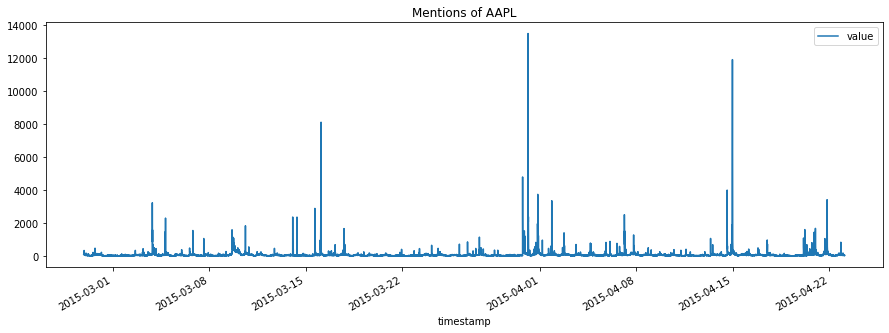

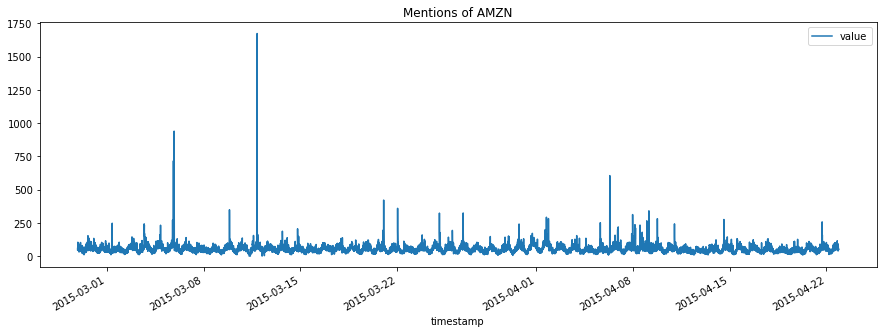

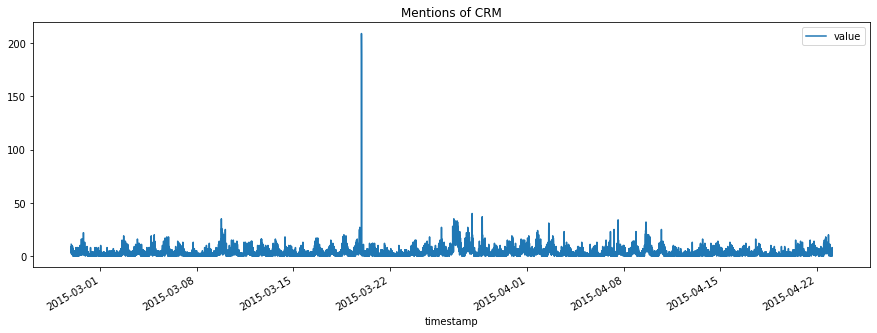

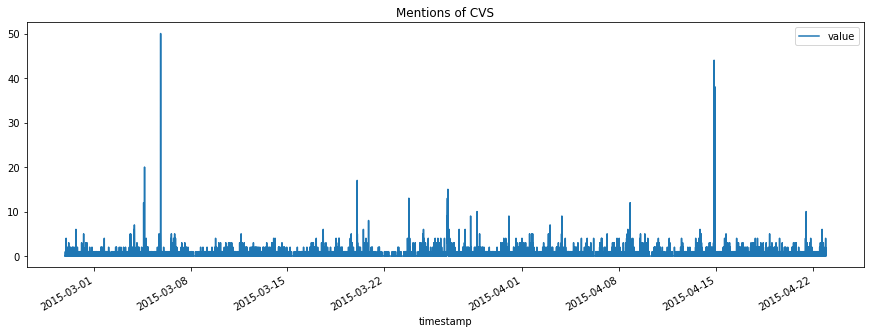

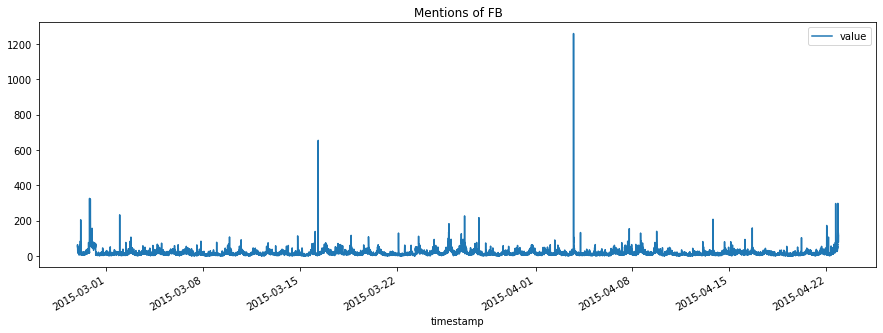

In [138]:
df[df['company'] == 'AAPL'].plot(x='timestamp', y='value', title='Mentions of AAPL', figsize=(15,5))
df[df['company'] == 'AMZN'].plot(x='timestamp', y='value', title='Mentions of AMZN', figsize=(15,5))
df[df['company'] == 'CRM'].plot(x='timestamp', y='value', title='Mentions of CRM', figsize=(15,5))
df[df['company'] == 'CVS'].plot(x='timestamp', y='value', title='Mentions of CVS', figsize=(15,5))
df[df['company'] == 'FB'].plot(x='timestamp', y='value', title='Mentions of FB', figsize=(15,5))

<AxesSubplot:title={'center':'Mentions of FB'}, xlabel='time_of_day', ylabel='value'>

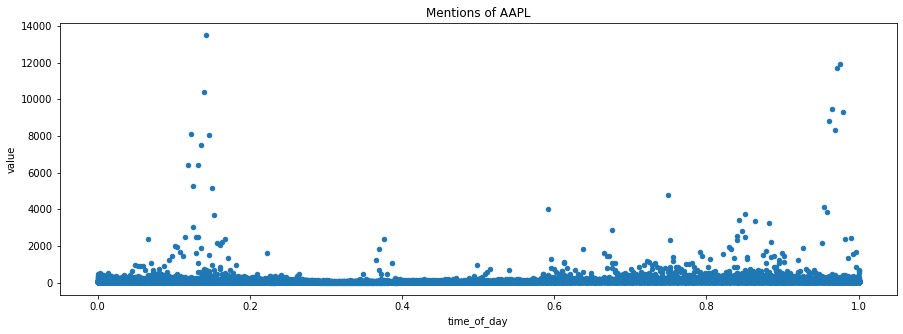

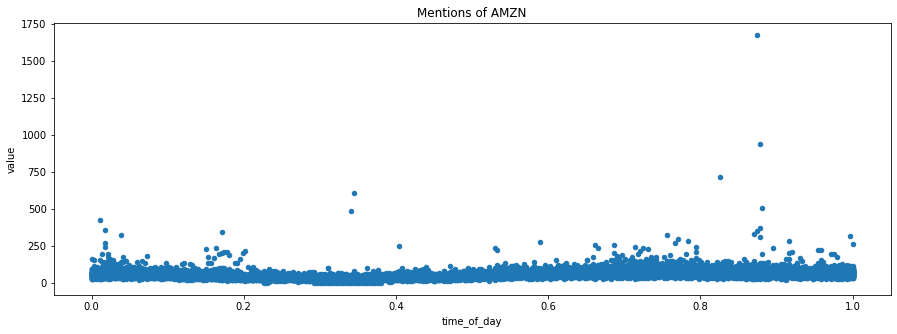

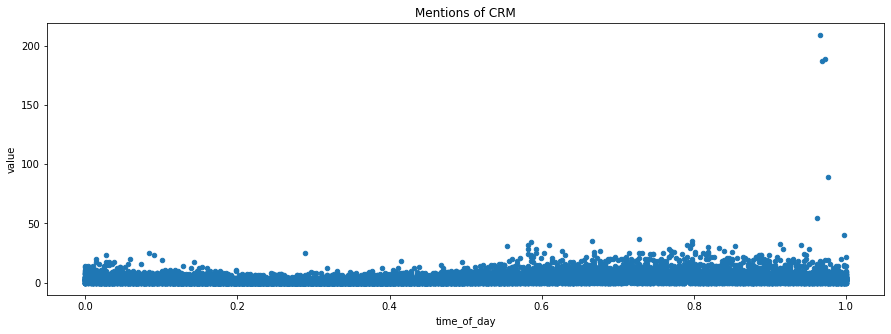

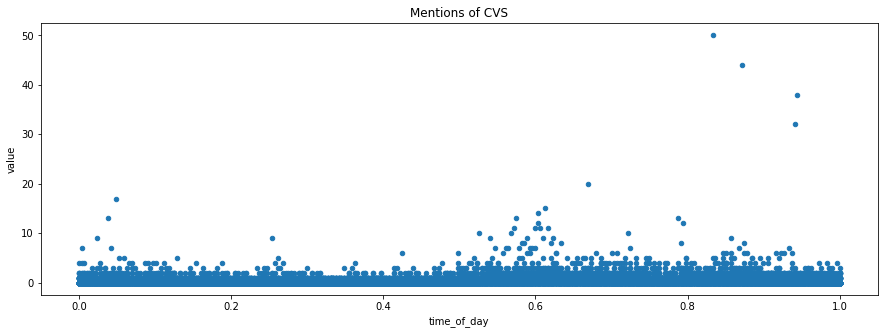

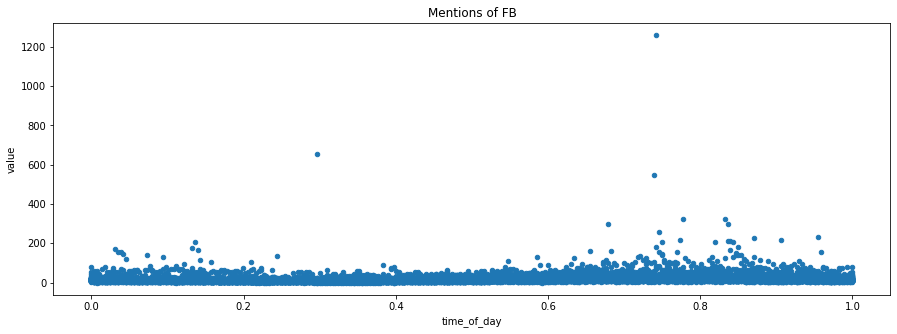

In [199]:
df[df['company'] == 'AAPL'].plot.scatter(x='time_of_day', y='value', title='Mentions of AAPL', figsize=(15,5))
df[df['company'] == 'AMZN'].plot.scatter(x='time_of_day', y='value', title='Mentions of AMZN', figsize=(15,5))
df[df['company'] == 'CRM'].plot.scatter(x='time_of_day', y='value', title='Mentions of CRM', figsize=(15,5))
df[df['company'] == 'CVS'].plot.scatter(x='time_of_day', y='value', title='Mentions of CVS', figsize=(15,5))
df[df['company'] == 'FB'].plot.scatter(x='time_of_day', y='value', title='Mentions of FB', figsize=(15,5))

<h3><b> Model Data </b></h3>
<br>
Here we will be splitting up the data to see what different results we will get. The different data sets will be:  

• just_val: Only using the values for anomaly detection

• time_val: Using both the values and also the timestamp

• all_vals: This is using all the created features along with the time and the original values

In [140]:
#data sets
just_val = df[["value"]].values
time_val = df[["value", "time_of_day"]].values

temp_df = df.drop("timestamp", axis=1)
le = preprocessing.LabelEncoder()
temp_df['company_label'] = le.fit_transform(df.company.values)
all_vals = temp_df.drop("company", axis=1).values

<h3><b>Models:</b></h3>
<br>
Here we will be testing every single data set against every model presented below for a total of 9 models. The different models being used are:

• Isolation Forest

• Local Outlier Factor

•One Class Support Vector Machine

In [141]:
#local outlier with just values
just_val_LOF = LocalOutlierFactor().fit_predict(just_val)
df['just_val_LOF_isAnomaly'] = pd.Series(just_val_LOF)

In [142]:
#local outlier with time and value
time_val_LOF = LocalOutlierFactor().fit_predict(time_val)
df['time_val_LOF_isAnomaly'] = pd.Series(time_val_LOF)

In [143]:
all_vals_LOF = LocalOutlierFactor().fit_predict(all_vals)
df['all_vals_LOF_isAnomaly'] = pd.Series(all_vals_LOF)

In [144]:
#SVM with just values
just_val_SVM = OneClassSVM().fit_predict(just_val)
df['just_val_SVM_isAnomaly'] = pd.Series(just_val_SVM)

In [145]:
#SVM with just time and values
time_val_SVM = OneClassSVM().fit_predict(time_val)
df['time_val_SVM_isAnomaly'] = pd.Series(time_val_SVM)

In [146]:
#SVM with all values
all_vals_SVM = OneClassSVM().fit_predict(all_vals)
df['all_vals_SVM_isAnomaly'] = pd.Series(all_vals_SVM)

In [147]:
#isolation forest
just_val_IF = IsolationForest().fit_predict(just_val)
df['just_val_IF_isAnomaly'] = pd.Series(just_val_IF)

In [148]:
#isolation forest
time_val_IF = IsolationForest().fit_predict(time_val)
df['time_val_IF_isAnomaly'] = pd.Series(time_val_IF)

In [149]:
#isolation forest
all_vals_IF = IsolationForest().fit_predict(all_vals)
df['all_vals_IF_isAnomaly'] = pd.Series(all_vals_IF)

<h3><b>Analysis</b></h3>
<br>
After training and predicting on all the models and the data, we will be analyzing it to see what worked best.

In [150]:
df

,timestamp,value,company,is_night,is_weekend,is_stock_hours,day_of_week,hour,month,time_of_day,just_val_LOF_isAnomaly,time_val_LOF_isAnomaly,all_vals_LOF_isAnomaly,just_val_SVM_isAnomaly,time_val_SVM_isAnomaly,all_vals_SVM_isAnomaly,just_val_IF_isAnomaly,time_val_IF_isAnomaly,all_vals_IF_isAnomaly
0,2015-02-26 21:42:53,104,AAPL,1,0,0,3,21,2,0.905923,1,-1,1,-1,-1,-1,-1,-1,-1
1,2015-02-26 21:47:53,100,AAPL,1,0,0,3,21,2,0.909408,1,1,1,-1,-1,-1,-1,-1,-1
2,2015-02-26 21:52:53,99,AAPL,1,0,0,3,21,2,0.912892,1,1,1,-1,-1,-1,-1,-1,-1
3,2015-02-26 21:57:53,154,AAPL,1,0,0,3,21,2,0.916376,1,1,1,-1,-1,-1,-1,-1,-1
4,2015-02-26 22:02:53,120,AAPL,1,0,0,3,22,2,0.919861,1,1,1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15828,2015-04-22 20:42:53,93,FB,1,0,0,2,20,4,0.864111,1,1,1,-1,-1,-1,1,-1,-1
15829,2015-04-22 20:47:53,101,FB,1,0,0,2,20,4,0.867596,1,1,1,-1,-1,-1,-1,-1,-1
15830,2015-04-22 20:52:53,132,FB,1,0,0,2,20,4,0.871080,1,1,1,-1,-1,-1,-1,-1,-1
15831,2015-04-22 20:57:53,78,FB,1,0,0,2,20,4,0.874564,1,1,1,-1,-1,-1,-1,-1,-1


In [151]:
df.describe()

,value,is_night,is_weekend,is_stock_hours,day_of_week,hour,month,time_of_day,just_val_LOF_isAnomaly,time_val_LOF_isAnomaly,all_vals_LOF_isAnomaly,just_val_SVM_isAnomaly,time_val_SVM_isAnomaly,all_vals_SVM_isAnomaly,just_val_IF_isAnomaly,time_val_IF_isAnomaly,all_vals_IF_isAnomaly
count,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000,79321.000000
mean,32.087203,0.417557,0.290465,0.332825,3.001097,11.498330,3.361077,0.499932,0.987519,0.934444,0.994327,0.086875,0.092296,0.087430,0.377340,0.147817,-0.915659
std,148.329589,0.493159,0.453980,0.471227,2.016301,6.929781,0.553941,0.290001,0.157500,0.356113,0.106369,0.996226,0.995738,0.996177,0.926081,0.989021,0.401958
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,5.000000,3.000000,0.247387,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,13.000000,0.000000,0.000000,0.000000,3.000000,11.000000,3.000000,0.498258,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000
75%,42.000000,1.000000,1.000000,1.000000,5.000000,18.000000,4.000000,0.752613,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000
max,13479.000000,1.000000,1.000000,1.000000,6.000000,23.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This cell below was used to see which models did the best and which did the worst. Later you will see that instead of individually going through every model, we will just look through all of them and graph it.

In [152]:
df[(df["all_vals_IF_isAnomaly"] == 1)]

,timestamp,value,company,is_night,is_weekend,is_stock_hours,day_of_week,hour,month,time_of_day,just_val_LOF_isAnomaly,time_val_LOF_isAnomaly,all_vals_LOF_isAnomaly,just_val_SVM_isAnomaly,time_val_SVM_isAnomaly,all_vals_SVM_isAnomaly,just_val_IF_isAnomaly,time_val_IF_isAnomaly,all_vals_IF_isAnomaly
1276,2015-03-03 08:02:53,18,AAPL,0,0,0,1,8,3,0.334495,1,1,1,1,1,1,1,1,1
1312,2015-03-03 11:02:53,29,AAPL,0,0,1,1,11,3,0.459930,1,1,1,1,1,1,1,1,1
1313,2015-03-03 11:07:53,20,AAPL,0,0,1,1,11,3,0.463415,1,1,1,1,1,1,1,1,1
1314,2015-03-03 11:12:53,22,AAPL,0,0,1,1,11,3,0.466899,1,1,1,1,1,1,1,1,1
1315,2015-03-03 11:17:53,25,AAPL,0,0,1,1,11,3,0.470383,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9382,2015-03-31 11:32:53,10,FB,0,0,1,1,11,3,0.480836,1,1,1,1,1,1,1,1,1
9383,2015-03-31 11:37:53,9,FB,0,0,1,1,11,3,0.484321,1,1,1,1,1,1,1,1,1
9384,2015-03-31 11:42:53,22,FB,0,0,1,1,11,3,0.487805,1,1,1,-1,1,1,1,1,1
9385,2015-03-31 11:47:53,18,FB,0,0,1,1,11,3,0.491289,1,1,1,1,1,1,1,1,1


Here we will graph all of the models against one company (just so that it is easier to look at) and see which one looks the best.
<br><br>
The reason that we have set it to -1 is because after some expermimintation it has shown better results for finding the anomalies

<AxesSubplot:title={'center':'all vals LOF anomalies'}, xlabel='time_of_day', ylabel='value'>

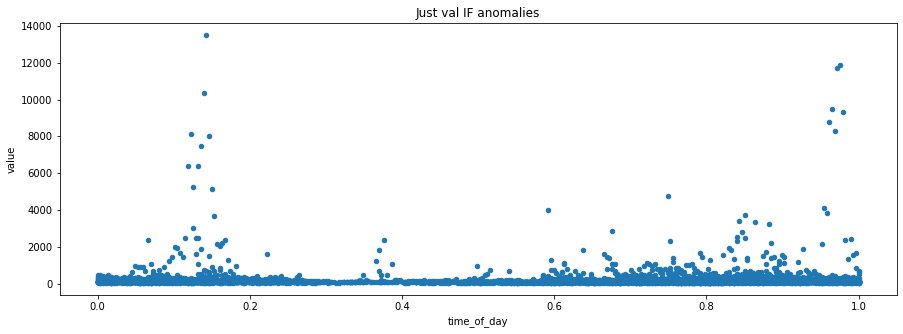

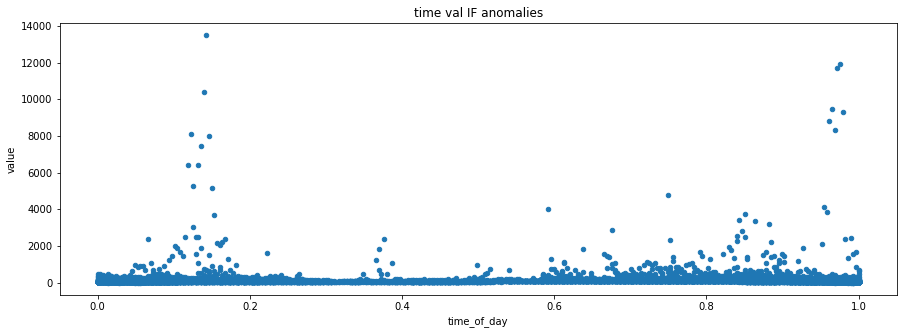

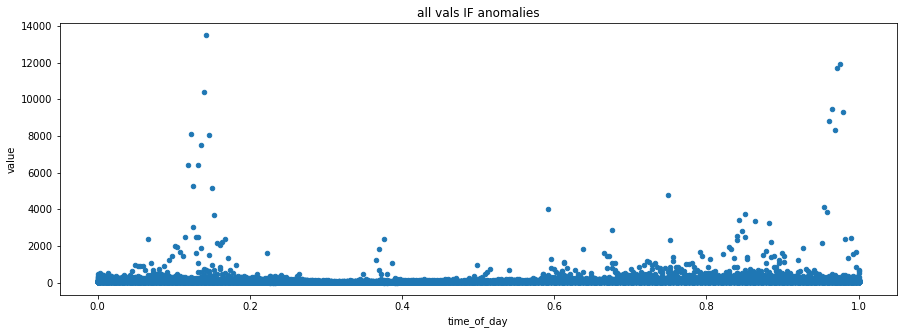

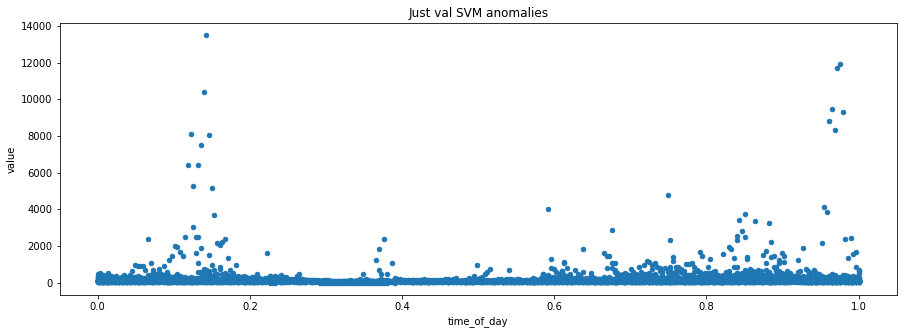

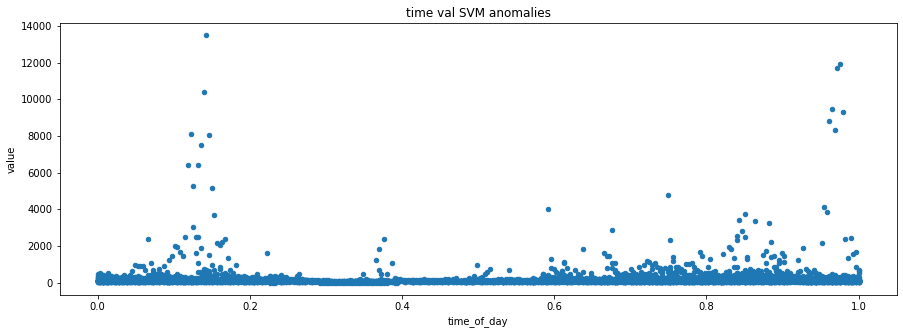

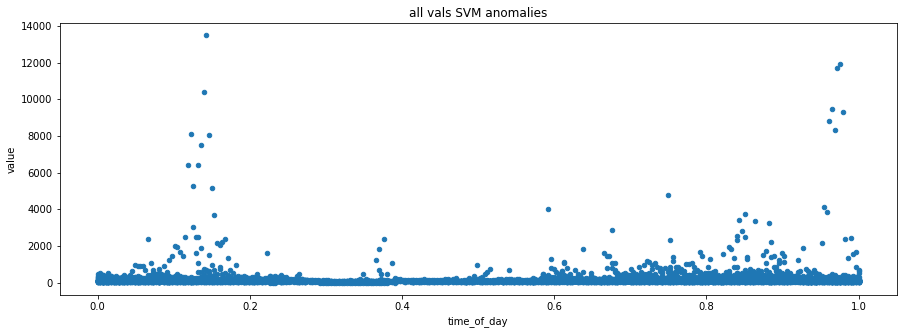

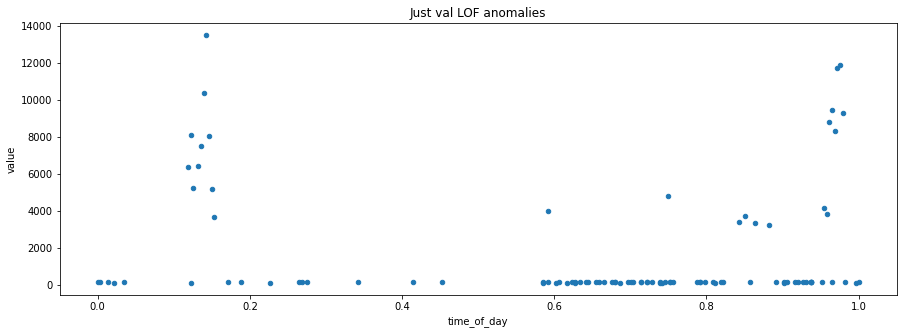

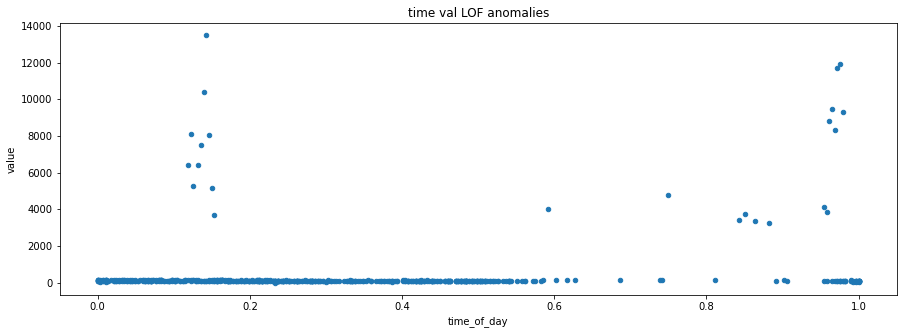

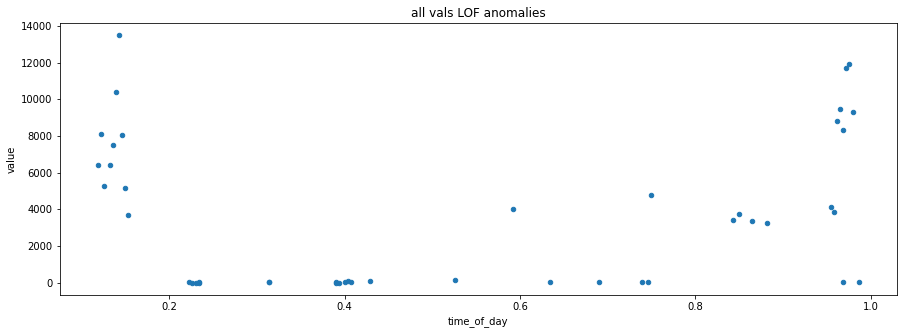

In [188]:
df[(df['company'] == 'AAPL') & (df['just_val_IF_isAnomaly'] == -1)].plot.scatter(x='time_of_day', y='value', title='Just val IF anomalies', figsize=(15,5))
df[(df['company'] == 'AAPL') & (df['time_val_IF_isAnomaly'] == -1)].plot.scatter(x='time_of_day', y='value', title='time val IF anomalies', figsize=(15,5))
df[(df['company'] == 'AAPL') & (df['all_vals_IF_isAnomaly'] == -1)].plot.scatter(x='time_of_day', y='value', title='all vals IF anomalies', figsize=(15,5))
df[(df['company'] == 'AAPL') & (df['just_val_SVM_isAnomaly'] == -1)].plot.scatter(x='time_of_day', y='value', title='Just val SVM anomalies', figsize=(15,5))
df[(df['company'] == 'AAPL') & (df['time_val_SVM_isAnomaly'] == -1)].plot.scatter(x='time_of_day', y='value', title='time val SVM anomalies', figsize=(15,5))
df[(df['company'] == 'AAPL') & (df['all_vals_SVM_isAnomaly'] == -1)].plot.scatter(x='time_of_day', y='value', title='all vals SVM anomalies', figsize=(15,5))
df[(df['company'] == 'AAPL') & (df['just_val_LOF_isAnomaly'] == -1)].plot.scatter(x='time_of_day', y='value', title='Just val LOF anomalies', figsize=(15,5))
df[(df['company'] == 'AAPL') & (df['time_val_LOF_isAnomaly'] == -1)].plot.scatter(x='time_of_day', y='value', title='time val LOF anomalies', figsize=(15,5))
df[(df['company'] == 'AAPL') & (df['all_vals_LOF_isAnomaly'] == -1)].plot.scatter(x='time_of_day', y='value', title='all vals LOF anomalies', figsize=(15,5))

After looking at all of the models, the best one by far was using the Local Outlier Factor model and by using the whole dataset instead of just a portion. Below, is a graph where the other companies data points have been color coded.

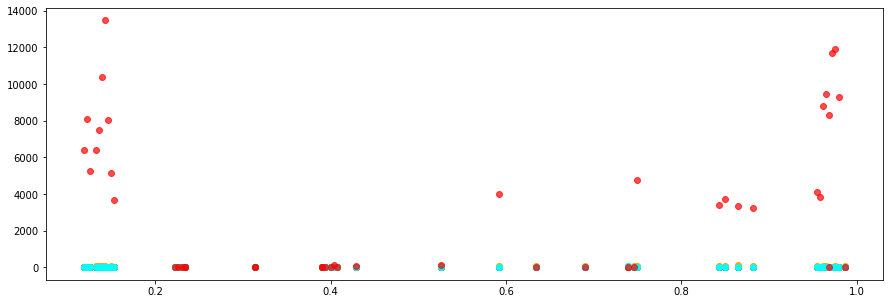

In [194]:
best_anomaly = df[df["all_vals_LOF_isAnomaly"] == -1]
fig = plt.figure(figsize=(15, 5))
plt.scatter(x=best_anomaly[best_anomaly["company"] == "CVS"].time_of_day.values, y=best_anomaly[best_anomaly["company"] == "CVS"].value.values, color='purple')
plt.scatter(x=best_anomaly[best_anomaly["company"] == "CRM"].time_of_day.values, y=best_anomaly[best_anomaly["company"] == "CRM"].value.values, color='g')
plt.scatter(x=best_anomaly[best_anomaly["company"] == "AMZN"].time_of_day.values, y=best_anomaly[best_anomaly["company"] == "AMZN"].value.values, color='orange')
plt.scatter(x=best_anomaly[best_anomaly["company"] == "FB"].time_of_day.values, y=best_anomaly[best_anomaly["company"] == "FB"].value.values, color='aqua')
plt.scatter(x=best_anomaly[best_anomaly["company"] == "AAPL"].time_of_day.values, y=best_anomaly[best_anomaly["company"] == "AAPL"].value.values, color='r', alpha=0.7)
plt.show()

Because there were so many apple mentions it was hard to see the rest of the data, for that reason, I have re graphed the data, but without the Apple mentions.

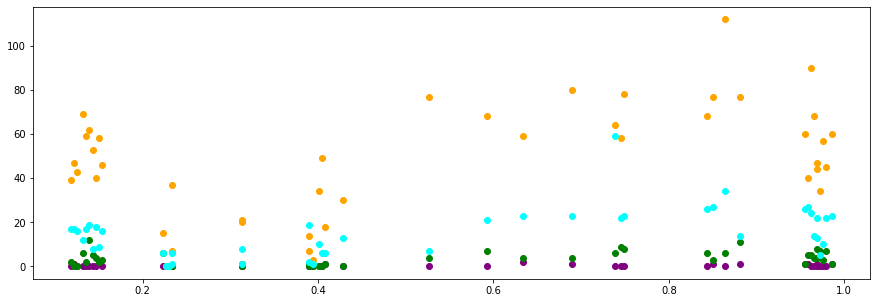

In [196]:
fig = plt.figure(figsize=(15, 5))
plt.scatter(x=best_anomaly[best_anomaly["company"] == "CVS"].time_of_day.values, y=best_anomaly[best_anomaly["company"] == "CVS"].value.values, color='purple')
plt.scatter(x=best_anomaly[best_anomaly["company"] == "CRM"].time_of_day.values, y=best_anomaly[best_anomaly["company"] == "CRM"].value.values, color='g')
plt.scatter(x=best_anomaly[best_anomaly["company"] == "AMZN"].time_of_day.values, y=best_anomaly[best_anomaly["company"] == "AMZN"].value.values, color='orange')
plt.scatter(x=best_anomaly[best_anomaly["company"] == "FB"].time_of_day.values, y=best_anomaly[best_anomaly["company"] == "FB"].value.values, color='aqua')

These results looked to be a little small so I decided to take a look at the results individually for each company. While the results seem to be partial to Apple, the other companies seem to have less amount of large results compared to Apple. This could be solved by having more data, but the results make sense for what the range of the other companies' mentions. 

In [201]:
df[df["company"] == 'FB'].describe()

,value,is_night,is_weekend,is_stock_hours,day_of_week,hour,month,time_of_day,just_val_LOF_isAnomaly,time_val_LOF_isAnomaly,all_vals_LOF_isAnomaly,just_val_SVM_isAnomaly,time_val_SVM_isAnomaly,all_vals_SVM_isAnomaly,just_val_IF_isAnomaly,time_val_IF_isAnomaly,all_vals_IF_isAnomaly
count,15833.000000,15833.000000,15833.000000,15833.000000,15833.000000,15833.000000,15833.000000,15833.000000,15833.000000,15833.000000,15833.000000,15833.000000,15833.000000,15833.000000,15833.000000,15833.000000,15833.000000
mean,17.811280,0.416409,0.291038,0.333481,3.002211,11.495800,3.359818,0.499827,0.987494,0.934314,0.994316,0.087349,0.092781,0.087981,0.377376,0.149624,-0.915493
std,19.740055,0.492979,0.454255,0.471471,2.018061,6.921052,0.553773,0.289635,0.157659,0.356461,0.106476,0.996209,0.995718,0.996154,0.926089,0.988774,0.402347
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,9.000000,0.000000,0.000000,0.000000,1.000000,5.000000,3.000000,0.247387,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,14.000000,0.000000,0.000000,0.000000,3.000000,11.000000,3.000000,0.498258,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000
75%,22.000000,1.000000,1.000000,1.000000,5.000000,17.000000,4.000000,0.749129,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000
max,1258.000000,1.000000,1.000000,1.000000,6.000000,23.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h2><b> Results </b></h2>
<br>
This project was to find anomalies. I believe that with this data, I was able to find many anomalies within the data and find which data points were anomalies within the data. This worked best for the Apple data set, this makes sense as I was taking the Apple data as a representative sample. For the most part, it still worked will in finding few and also extraneous data points within all of the data sets. 
<br>
Some things that I could have done differently would be to have added more features. This could have been by extrapolating more information from the values column instead of everything from just the timestamp column. I could have also tuned the hyper parameters of the models more. 